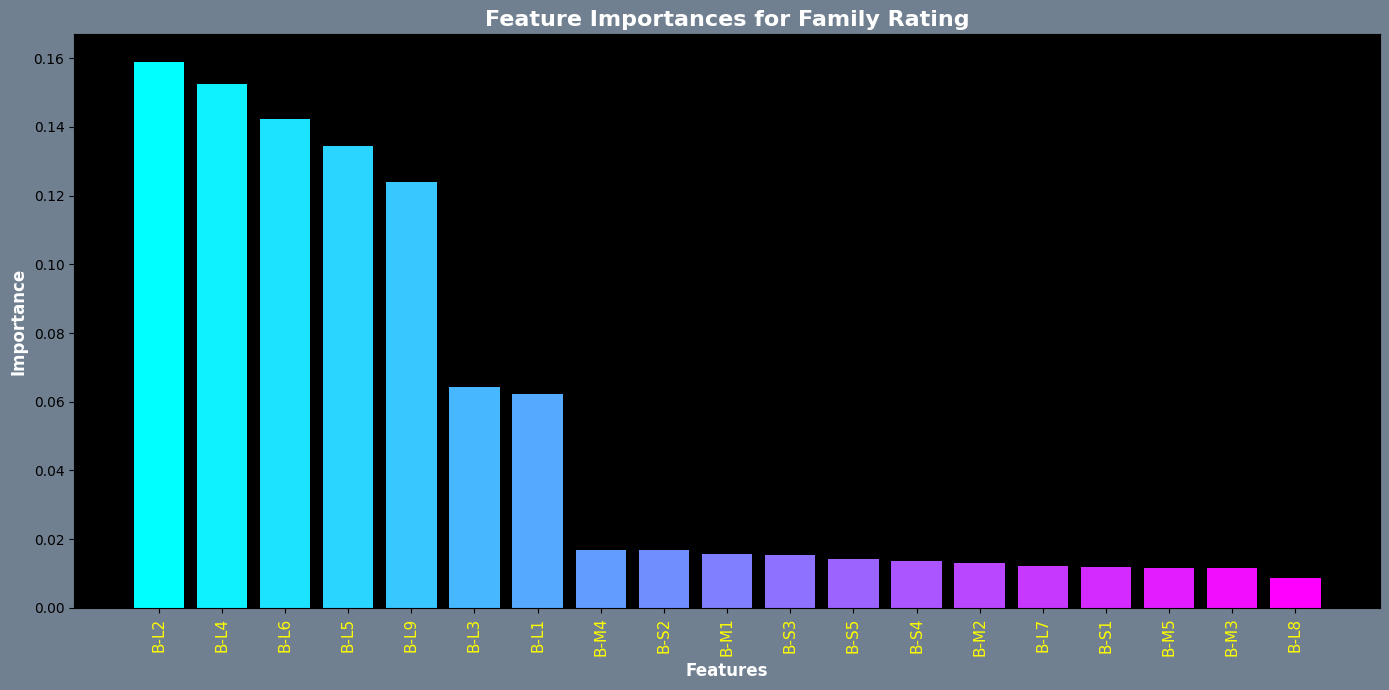

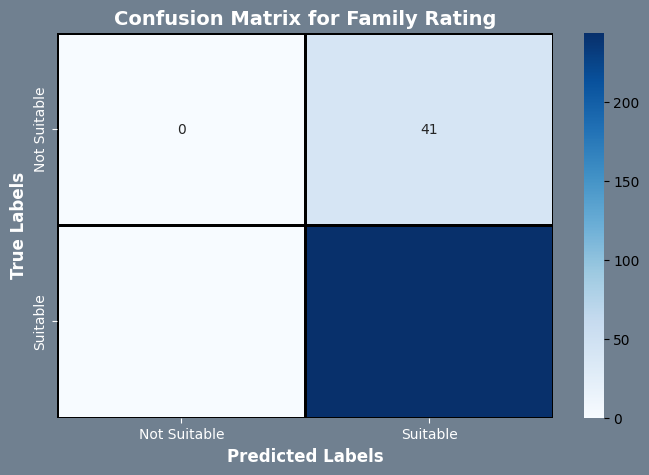

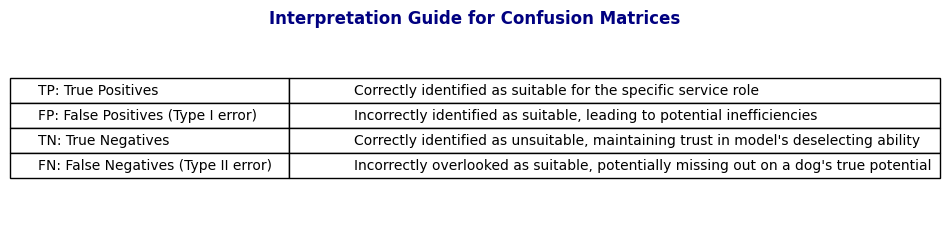

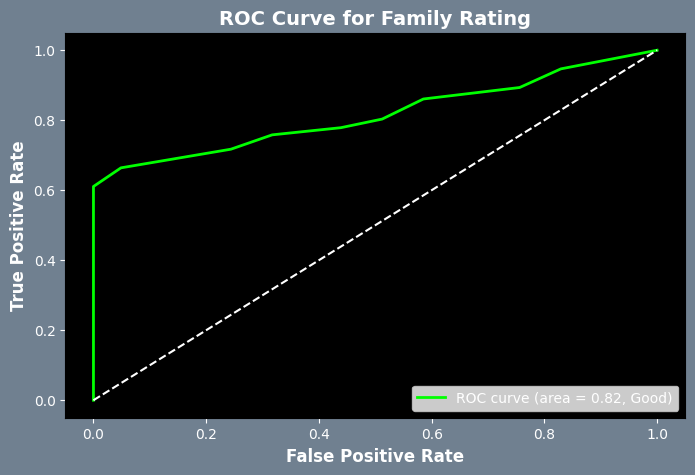

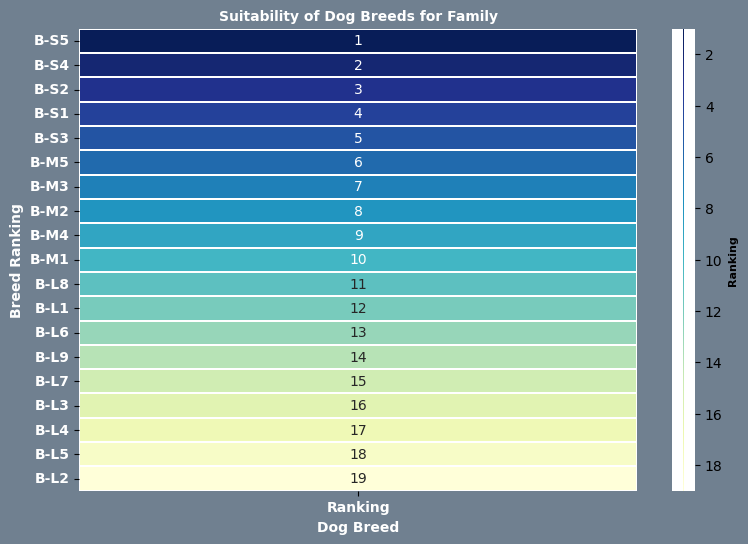

In [1]:
# Author: Uma Rao
# Class: ML 4375
# Project: Year-End Project
# This script evaluates the suitability of different dog breeds for various service roles using a RandomForestClassifier.
# The evaluations are based on a specific service type rating, aiming to predict whether dogs are suitable for designated roles.
#
# Observations:
# - Model performance is analyzed using a confusion matrix and ROC curves to validate the effectiveness.
# - Feature importance is examined to identify key predictors influencing suitability assessments.
# - Visual tools such as heatmaps and ROC curves provide insights into the model's predictive capabilities and errors.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import NotFittedError

class DogServiceRatingClassifier:
    # Constructor to initialize the classifier with the dataset and service type
    def __init__(self, filepath, service_type_rating):
        self.df = pd.read_csv(filepath)
        self.service_type_rating = service_type_rating  # Use this variable throughout your class
        self.service_type = self.service_type_rating.replace(' Rating', '')  # Truncate ' Rating'
        self.model = RandomForestClassifier(
            n_estimators=100, max_depth=15, min_samples_split=4,
            min_samples_leaf=4, max_features='sqrt', random_state=42
        )
        self.setup_data()
        
    # Prepares data by encoding features and splitting into train/test sets
    def setup_data(self):
        # Encode 'Dog Breed' using OneHotEncoder
        column_transformer = ColumnTransformer(
            [('dog_breed_one_hot', OneHotEncoder(), ['Dog Breed'])],
            remainder='drop'
        )

        X = column_transformer.fit_transform(self.df[['Dog Breed']])
        self.features = column_transformer.get_feature_names_out()

        # Convert rating to binary classes based on the threshold 0.5
        y = (self.df[self.service_type_rating] > 0.5).astype(int)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Fit the model
        self.model.fit(self.X_train, self.y_train)

    # Plots the feature importance of the trained RandomForest model
    def plot_feature_importance(self):
        if not hasattr(self.model, 'feature_importances_'):
            raise NotFittedError("Model not trained. Call `setup_data` first.")

        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Setting figure and background
        plt.figure(figsize=(14, 7))
        plt.gca().set_facecolor('black')
        plt.gcf().set_facecolor('slategray')

        # Truncate prefix from feature names for x-axis labels
        truncated_labels = [label.split('_')[-1] for label in self.features[indices]]

        # Use a vivid color map
        colors = plt.cm.cool(np.linspace(0, 1, len(indices)))

        # Plotting feature importances with vivid colors
        plt.bar(range(len(indices)), importances[indices], color=colors, align='center')
        plt.xticks(range(len(indices)), truncated_labels, rotation=90, fontsize=11, color='yellow')  # Increase font size and use yellow color

        # Customize title and labels
        plt.title(f'Feature Importances for {self.service_type_rating}', fontsize=16, fontweight='bold', color='white')
        plt.xlabel('Features', fontsize=12, fontweight='bold', color='white')
        plt.ylabel('Importance', fontsize=12, fontweight='bold', color='white')

        plt.tight_layout()
        plt.show()  


    # Plots a confusion matrix to evaluate classifier performance
    def plot_confusion_matrix(self):
        y_pred = self.model.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)
        labels = ['Not Suitable', 'Suitable']  # These should correspond to 0 and 1 in your y_test

        # Create figure and axis objects and set the background colors
        fig, ax = plt.subplots(figsize=(8, 5))
        fig.patch.set_facecolor('slategray')  # Set the background color of the figure to black
        ax.set_facecolor('black')  # Set the background color of the axes to slate gray

        # Create a heatmap for the confusion matrix with custom annotation styling
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax, cbar=True, linewidths=1, linecolor='black')

        # Customize the title, labels, and ticks
        ax.set_title(f'Confusion Matrix for {self.service_type_rating}', fontsize=14, fontweight='bold', color='white')
        ax.set_xlabel('Predicted Labels', fontsize=12, fontweight='bold', color='white')
        ax.set_ylabel('True Labels', fontsize=12, fontweight='bold', color='white')

        # Change the color of axis ticks
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.set_xticklabels(labels, color='white')
        ax.set_yticklabels(labels, color='white')
        

        plt.show()
        
        self.plot_interpretation_guide()

    # Provides a text guide to interpret the confusion matrix
    def plot_interpretation_guide(self):
        fig, ax = plt.subplots(figsize=(8, 2.5))  # Adjust size as needed
        ax.axis('off')
        interpretation_data = [
            ["TP: True Positives", "Correctly identified as suitable for the specific service role"],
            ["FP: False Positives (Type I error)", "Incorrectly identified as suitable, leading to potential inefficiencies"],
            ["TN: True Negatives", "Correctly identified as unsuitable, maintaining trust in model's deselecting ability"],
            ["FN: False Negatives (Type II error)", "Incorrectly overlooked as suitable, potentially missing out on a dog's true potential"]
        ]
        table = ax.table(cellText=interpretation_data, cellLoc='left', loc='center', colWidths=[0.3, 0.7])
        table.auto_set_font_size(False)
        table.set_fontsize(10)  # Set font size
        table.scale(1.5, 1.5)  # Scale the table for better readability

        plt.title('Interpretation Guide for Confusion Matrices', fontsize=12, fontweight='bold', color='navy')
        plt.show()

 

    # Plots an ROC curve to visualize classifier performance
    def plot_roc_curve(self):
        # Predict probabilities for the positive class
        y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
        roc_auc = roc_auc_score(self.y_test, y_pred_proba)

        # Determine the ROC interpretation
        if roc_auc >= 0.9:
            interpretation = 'Excellent'
        elif roc_auc >= 0.75:
            interpretation = 'Good'
        elif roc_auc >= 0.6:
            interpretation = 'Fair'
        else:
            interpretation = 'Poor'

        # Create figure and axis objects and set the background colors
        fig, ax = plt.subplots(figsize=(8, 5))
        fig.patch.set_facecolor('slategray')  # Set the background color of the figure to black
        ax.set_facecolor('black')  # Set the background color of the axes to slate gray

        # Plot the ROC curve and the random line
        ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}, {interpretation})', color='lime', linewidth=2)
        ax.plot([0, 1], [0, 1], '--', color='white')

        # Customize the title, labels, legend, and axis ticks
        ax.set_title(f'ROC Curve for {self.service_type_rating}', fontsize=14, fontweight='bold', color='white')
        ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold', color='white')
        ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold', color='white')
        legend = ax.legend(loc="lower right")
        plt.setp(legend.get_texts(), color='white')  # Set the legend text to white

        # Change the color of the axis ticks
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')

        plt.show()


    # Plots a heatmap of breed suitability rankings based on average ratings
    def plot_suitability_table(self):
        # Compute the mean rating for '{self.service_type_rating}', rank them, and convert to integer for clear rankings
        suitability = self.df.groupby('Dog Breed')[self.service_type_rating].mean().rank(method='dense', ascending=False).astype(int)
        suitability_df = suitability.to_frame('Ranking')
        suitability_df = suitability_df.sort_values('Ranking', ascending=True)  # Sort by ranking ascending for visualization

        plt.figure(figsize=(9, 6), facecolor='slategray')
        ax = plt.gca()
        ax.set_facecolor('black')

        # Create a heatmap and explicitly set the color range to match the ranking values
        heatmap = sns.heatmap(suitability_df, annot=True, fmt="d", cmap='YlGnBu_r', linewidths=0.2, cbar_kws={'label': 'Ranking'},
                              vmin=1, vmax=suitability_df['Ranking'].max())  # Ensure vmin and vmax encompass all rank values

        # Adjust the color bar
        cbar = heatmap.collections[0].colorbar
        cbar.set_label('Ranking', size=8, weight='bold')
        cbar.ax.invert_yaxis()  # This inverts the color bar
        cbar.ax.set_aspect(20)  # Adjust this value to match the height of the heatmap

        plt.title(f'Suitability of Dog Breeds for {self.service_type}', fontsize=10, fontweight='bold', color='white')
        plt.xlabel('Dog Breed', fontsize=10, fontweight='bold', color='white')
        plt.ylabel('Breed Ranking', fontsize=10, fontweight='bold', color='white')

        # Change the color of ticks and labels to white for visibility on dark background
        plt.xticks(fontsize=10, fontweight='bold', color='white')
        plt.yticks(fontsize=10, fontweight='bold', color='white')

        plt.show()



####################################
# M A I N   M E T H O D
####################################
def main():
    filepath = 'synthetic_dog_data.csv'  # Adjust the filepath as necessary
    classifier = DogServiceRatingClassifier(filepath, 'Family Rating')
    classifier.plot_feature_importance()
    classifier.plot_confusion_matrix()
    classifier.plot_roc_curve()
    classifier.plot_suitability_table()

if __name__ == "__main__":
    main()
